## Analysis of Boston's and Seattle's Airbnb Data
Airbnb is a digital accomodation marketplace founded in 2008. It links hosts and travellers across more than 1,000 markets around the world (Airbnb Incorporated, "About us", https://press.airbnb.com/about-us/, 31.03.2019). This analysis relies on public Airbnb data and uses the methods of advanced analytics to answer the following business questions:
##### 1. What is the market situation like in both cities? Are there differences?
##### 2. Which are the most expensive neighbourhoods? And in which neighbourhoods most accomodations are offered?
##### 3. What are the main price drivers for Airbnb listings in these two cities?

#### Import of Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import MinMaxScaler

#### Loading Data

In [2]:
# Load Seattle & Boston Airbnb Data
seattle_calendar_df = pd.read_csv('Data\\seattle_calendar.csv')
seattle_reviews_df = pd.read_csv('Data\\seattle_reviews.csv')
seattle_listing_df = pd.read_csv('Data\\seattle_listings.csv')
boston_calendar_df = pd.read_csv('Data\\boston_calendar.csv')
boston_reviews_df = pd.read_csv('Data\\boston_reviews.csv')
boston_listing_df = pd.read_csv('Data\\boston_listings.csv')

# Concatenate Seattle & Boston Data
calendar_df = pd.concat([seattle_calendar_df, boston_calendar_df])
reviews_df = pd.concat([seattle_reviews_df, boston_reviews_df])
listing_df = pd.concat([seattle_listing_df, boston_listing_df], keys= ['Seattle','Boston'])

# Rename Key Column in Listing Data
listing_df.reset_index(level=0, inplace=True)
listing_df.rename(columns={'level_0': 'City_Index'}, inplace=True)

## I. Data Understanding

### 1. First Examination of the Data

In [3]:
print('\n----- Shape of Seattle Data -----')
print('Shape of Calendar Data: ' + str(seattle_calendar_df.shape))
print('Shape of Review Data: ' + str(seattle_reviews_df.shape))
print('Shape of Listing Data: ' + str(seattle_listing_df.shape))
print('\n----- Shape of Boston Data -----')
print('Shape of Calendar Data: ' + str(boston_calendar_df.shape))
print('Shape of Review Data: ' + str(boston_reviews_df.shape))
print('Shape of Listing Data: ' + str(boston_listing_df.shape))
print('\n----- Shape after Concatenation -----')
print('Shape of Calendar Data: ' + str(calendar_df.shape))
print('Shape of Review Data: ' + str(reviews_df.shape))
print('Shape of Listing Data: ' + str(listing_df.shape))

print('\n------------ Validation -------------\n'+ str(listing_df.groupby(['City_Index']).size()))


----- Shape of Seattle Data -----
Shape of Calendar Data: (1393570, 4)
Shape of Review Data: (84849, 6)
Shape of Listing Data: (3818, 92)

----- Shape of Boston Data -----
Shape of Calendar Data: (1308890, 4)
Shape of Review Data: (68275, 6)
Shape of Listing Data: (3585, 95)

----- Shape after Concatenation -----
Shape of Calendar Data: (2702460, 4)
Shape of Review Data: (153124, 6)
Shape of Listing Data: (7403, 96)

------------ Validation -------------
City_Index
Boston     3585
Seattle    3818
dtype: int64


#### 1.1. Calendar Data

In [4]:
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


#### 1.2. Review Data

In [5]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


#### 1.3. Listing Data

In [6]:
listing_df.head()

,City_Index,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,...,space,square_feet,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,Seattle,NaN,4,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",14,346,41,71,1.0,Real Bed,...,Make your self at home in this charming one-be...,NaN,WA,"Gilman Dr W, Seattle, WA 98119, United States",NaN,NaN,NaN,NaN,NaN,98119
1,Seattle,NaN,4,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",13,291,13,16,1.0,Real Bed,...,"Beautiful, hypoallergenic apartment in an extr...",NaN,WA,"7th Avenue West, Seattle, WA 98119, United States",Chemically sensitive? We've removed the irrita...,https://a0.muscache.com/ac/pictures/14409893/f...,"Convenient bus stops are just down the block, ...","$1,000.00",https://a0.muscache.com/ac/pictures/14409893/f...,98119
2,Seattle,NaN,11,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,220,6,17,4.5,Real Bed,...,"Our house is modern, light and fresh with a wa...",NaN,WA,"West Lee Street, Seattle, WA 98119, United States",New modern house built in 2013. Spectacular s...,NaN,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,98119
3,Seattle,NaN,3,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",0,143,0,0,1.0,Real Bed,...,NaN,NaN,WA,"8th Avenue West, Seattle, WA 98119, United States",A charming apartment that sits atop Queen Anne...,NaN,NaN,$650.00,NaN,98119
4,Seattle,NaN,6,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",30,365,60,90,2.0,Real Bed,...,Cozy family craftman house in beautiful neighb...,NaN,WA,"14th Ave W, Seattle, WA 98119, United States",Cozy family craftman house in beautiful neighb...,NaN,The nearest public transit bus (D Line) is 2 b...,NaN,NaN,98119


### 2. Change Data Types

#### 2.1. Calendar Data

In [7]:
# Check data types
calendar_df.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [8]:
# Convert 'price' into float
calendar_df.price = calendar_df.price.str.replace('$','')
calendar_df.price = calendar_df.price.str.replace(',','')
calendar_df.price = calendar_df.price.astype(float)

In [9]:
# Convert 'date' into datetime
calendar_df.date = pd.to_datetime(calendar_df.date)

In [10]:
# Dummying Coding of 'available'
calendar_df.available = calendar_df.available.replace('t',1)
calendar_df.available = calendar_df.available.replace('f',0)

In [11]:
# Convert 'date' into datetime
seattle_calendar_df.date = pd.to_datetime(seattle_calendar_df.date)

In [12]:
# Convert 'date' into datetime
boston_calendar_df.date = pd.to_datetime(boston_calendar_df.date)

In [13]:
# Convert 'price' into float
seattle_calendar_df.price = seattle_calendar_df.price.str.replace('$','')
seattle_calendar_df.price = seattle_calendar_df.price.str.replace(',','')
seattle_calendar_df.price = seattle_calendar_df.price.astype(float)

In [14]:
# Convert 'price' into float
boston_calendar_df.price = boston_calendar_df.price.str.replace('$','')
boston_calendar_df.price = boston_calendar_df.price.str.replace(',','')
boston_calendar_df.price = boston_calendar_df.price.astype(float)

In [15]:
# Preview
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,1,85.0
1,241032,2016-01-05,1,85.0
2,241032,2016-01-06,0,NaN
3,241032,2016-01-07,0,NaN
4,241032,2016-01-08,0,NaN


#### 2.2. Review Data

In [16]:
# Check data types
reviews_df.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

In [17]:
# Convert 'date' into datetime
reviews_df.date = pd.to_datetime(reviews_df.date)

In [18]:
# Convert 'date' into datetime
seattle_reviews_df.date = pd.to_datetime(seattle_reviews_df.date)

In [19]:
# Convert 'date' into datetime
boston_reviews_df.date = pd.to_datetime(boston_reviews_df.date)

In [20]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


#### 2.3. Listing Data

In [21]:
# Check data types
for feature in listing_df.columns:
    print(listing_df[feature].head())
    print('\n')

0    Seattle
1    Seattle
2    Seattle
3    Seattle
4    Seattle
Name: City_Index, dtype: object


0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: access, dtype: object


0     4
1     4
2    11
3     3
4     6
Name: accommodates, dtype: int64


0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
3    {Internet,"Wireless Internet",Kitchen,"Indoor ...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, dtype: object


0    14
1    13
2     1
3     0
4    30
Name: availability_30, dtype: int64


0    346
1    291
2    220
3    143
4    365
Name: availability_365, dtype: int64


0    41
1    13
2     6
3     0
4    60
Name: availability_60, dtype: int64


0    71
1    16
2    17
3     0
4    90
Name: availability_90, dtype: int64


0    1.0
1    1.0
2    4.5
3    1.0
4    2.0
Name: bathrooms, dtype: float64


0    Real Bed
1    Real Bed
2    Real Bed
3   

In [22]:
# Convert 'last_scraped' into datetime
listing_df.last_scraped = pd.to_datetime(listing_df.last_scraped)

In [23]:
# Convert 'host_since' into datetime
listing_df.host_since = pd.to_datetime(listing_df.host_since)

In [24]:
# Convert 'host_response_rate' into float
listing_df.host_response_rate = listing_df.host_response_rate.str.replace('%','')
listing_df.host_response_rate = listing_df.host_response_rate.astype(float)
listing_df.host_response_rate = listing_df.host_response_rate / 100

In [25]:
# Convert 'host_acceptance_rate' into float
listing_df.host_acceptance_rate = listing_df.host_acceptance_rate.str.replace('%','')
listing_df.host_acceptance_rate = listing_df.host_acceptance_rate.astype(float)
listing_df.host_acceptance_rate = listing_df.host_acceptance_rate / 100

In [26]:
# Dummying Coding of 'host_is_superhost'
listing_df.host_is_superhost = listing_df.host_is_superhost.replace('t',1)
listing_df.host_is_superhost = listing_df.host_is_superhost.replace('f',0)

In [27]:
# Dummying Coding of 'host_has_profile_pic'
listing_df.host_has_profile_pic = listing_df.host_has_profile_pic.replace('t',1)
listing_df.host_has_profile_pic = listing_df.host_has_profile_pic.replace('f',0)

In [28]:
# Dummying Coding of 'host_identity_verified'
listing_df.host_identity_verified = listing_df.host_identity_verified.replace('t',1)
listing_df.host_identity_verified = listing_df.host_identity_verified.replace('f',0)

In [29]:
# Dummying Coding of 'is_location_exact'
listing_df.is_location_exact = listing_df.is_location_exact.replace('t',1)
listing_df.is_location_exact = listing_df.is_location_exact.replace('f',0)

In [30]:
# Convert 'price' into float
listing_df.price = listing_df.price.str.replace('$','')
listing_df.price = listing_df.price.str.replace(',','')
listing_df.price = listing_df.price.astype(float)
seattle_listing_df.price = seattle_listing_df.price.str.replace('$','')
seattle_listing_df.price = seattle_listing_df.price.str.replace(',','')
seattle_listing_df.price = seattle_listing_df.price.astype(float)
boston_listing_df.price = boston_listing_df.price.str.replace('$','')
boston_listing_df.price = boston_listing_df.price.str.replace(',','')
boston_listing_df.price = boston_listing_df.price.astype(float)

In [31]:
# Convert 'weekly_price' into float
listing_df.weekly_price = listing_df.weekly_price.str.replace('$','')
listing_df.weekly_price = listing_df.weekly_price.str.replace(',','')
listing_df.weekly_price = listing_df.weekly_price.astype(float)

In [32]:
# Convert 'monthly_price' into float
listing_df.monthly_price = listing_df.monthly_price.str.replace('$','')
listing_df.monthly_price = listing_df.monthly_price.str.replace(',','')
listing_df.monthly_price = listing_df.monthly_price.astype(float)

In [33]:
# Convert 'security_deposit' into float
listing_df.security_deposit = listing_df.security_deposit.str.replace('$','')
listing_df.security_deposit = listing_df.security_deposit.str.replace(',','')
listing_df.security_deposit = listing_df.security_deposit.astype(float)

In [34]:
# Convert 'cleaning_fee' into float
listing_df.cleaning_fee = listing_df.cleaning_fee.str.replace('$','')
listing_df.cleaning_fee = listing_df.cleaning_fee.str.replace(',','')
listing_df.cleaning_fee = listing_df.cleaning_fee.astype(float)

In [35]:
# Convert 'extra_people' into float
listing_df.extra_people = listing_df.extra_people.str.replace('$','')
listing_df.extra_people = listing_df.extra_people.str.replace(',','')
listing_df.extra_people = listing_df.extra_people.astype(float)

In [36]:
# Dummying Coding of 'has_availability'
listing_df.has_availability = listing_df.has_availability.replace('t',1)
listing_df.has_availability = listing_df.has_availability.replace('f',0)

In [37]:
# Convert 'calendar_last_scraped' into datetime
listing_df.calendar_last_scraped = pd.to_datetime(listing_df.calendar_last_scraped)

In [38]:
# Convert 'first_review' into datetime
listing_df.first_review = pd.to_datetime(listing_df.first_review)

In [39]:
# Convert 'last_review' into datetime
listing_df.last_review = pd.to_datetime(listing_df.last_review)

In [40]:
# Dummying Coding of 'requires_license'
listing_df.requires_license = listing_df.requires_license.replace('t',1)
listing_df.requires_license = listing_df.requires_license.replace('f',0)

In [41]:
# Dummying Coding of 'instant_bookable'
listing_df.instant_bookable = listing_df.instant_bookable.replace('t',1)
listing_df.instant_bookable = listing_df.instant_bookable.replace('f',0)

In [42]:
# Dummying Coding of 'require_guest_profile_picture'
listing_df.require_guest_profile_picture = listing_df.require_guest_profile_picture.replace('t',1)
listing_df.require_guest_profile_picture = listing_df.require_guest_profile_picture.replace('f',0)

In [43]:
# Dummying Coding of 'require_guest_phone_verification'
listing_df.require_guest_phone_verification = listing_df.require_guest_phone_verification.replace('t',1)
listing_df.require_guest_phone_verification = listing_df.require_guest_phone_verification.replace('f',0)

In [44]:
listing_df.head()

,City_Index,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,...,space,square_feet,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,Seattle,NaN,4,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",14,346,41,71,1.0,Real Bed,...,Make your self at home in this charming one-be...,NaN,WA,"Gilman Dr W, Seattle, WA 98119, United States",NaN,NaN,NaN,NaN,NaN,98119
1,Seattle,NaN,4,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",13,291,13,16,1.0,Real Bed,...,"Beautiful, hypoallergenic apartment in an extr...",NaN,WA,"7th Avenue West, Seattle, WA 98119, United States",Chemically sensitive? We've removed the irrita...,https://a0.muscache.com/ac/pictures/14409893/f...,"Convenient bus stops are just down the block, ...",1000.0,https://a0.muscache.com/ac/pictures/14409893/f...,98119
2,Seattle,NaN,11,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,220,6,17,4.5,Real Bed,...,"Our house is modern, light and fresh with a wa...",NaN,WA,"West Lee Street, Seattle, WA 98119, United States",New modern house built in 2013. Spectacular s...,NaN,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,98119
3,Seattle,NaN,3,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",0,143,0,0,1.0,Real Bed,...,NaN,NaN,WA,"8th Avenue West, Seattle, WA 98119, United States",A charming apartment that sits atop Queen Anne...,NaN,NaN,650.0,NaN,98119
4,Seattle,NaN,6,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",30,365,60,90,2.0,Real Bed,...,Cozy family craftman house in beautiful neighb...,NaN,WA,"14th Ave W, Seattle, WA 98119, United States",Cozy family craftman house in beautiful neighb...,NaN,The nearest public transit bus (D Line) is 2 b...,NaN,NaN,98119


### 3. Listing Development over the Year

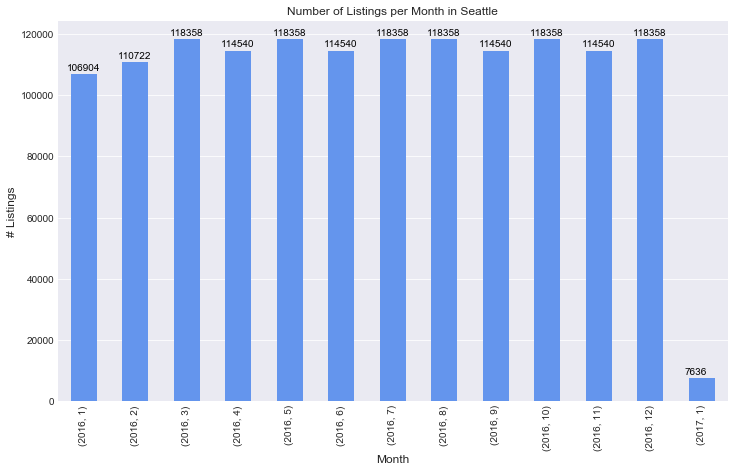

In [45]:
# Setup Plot
sns.set_style('darkgrid')
seattle_calendar_df.date.groupby([seattle_calendar_df['date'].dt.year, seattle_calendar_df['date'].dt.month]).count().plot(kind='bar', color='cornflowerblue', figsize=(12,7)).xaxis.grid()
plt.title('Number of Listings per Month in Seattle')
plt.ylabel('# Listings', fontsize=12)
plt.xlabel('Month', fontsize=12)

# Create Labels
for i in range(13):
    plt.text(x = -0.33+i, 
             y=seattle_calendar_df.date.groupby([seattle_calendar_df['date'].dt.year, seattle_calendar_df['date'].dt.month]).count()[i]+2000, 
             s=seattle_calendar_df.date.groupby([seattle_calendar_df['date'].dt.year, seattle_calendar_df['date'].dt.month]).count()[i], 
             color = 'black', fontsize=10, va='center')
# Show Plot
plt.show()

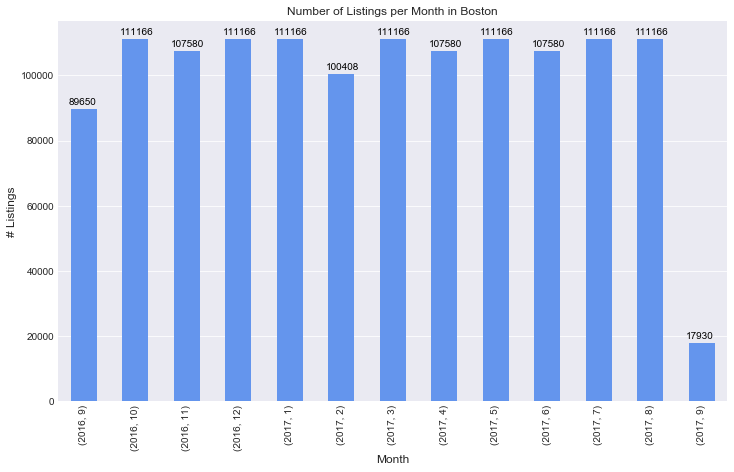

In [46]:
# Setup Plot
boston_calendar_df.date.groupby([boston_calendar_df['date'].dt.year, boston_calendar_df['date'].dt.month]).count().plot(kind='bar', color='cornflowerblue', figsize=(12,7)).xaxis.grid()
plt.title('Number of Listings per Month in Boston')
plt.ylabel('# Listings', fontsize=12)
plt.xlabel('Month', fontsize=12)

# Create Labels
for i in range(13):
    plt.text(x = -0.3+i, 
             y=boston_calendar_df.date.groupby([boston_calendar_df['date'].dt.year, boston_calendar_df['date'].dt.month]).count()[i]+2000, 
             s=boston_calendar_df.date.groupby([boston_calendar_df['date'].dt.year, boston_calendar_df['date'].dt.month]).count()[i], 
             color = 'black', fontsize=10, va='center')

# Show Plot
plt.show()

#### Number of Listings over Time
The number of listings has peaks in January, March, May, July, August, October, December in Boston and Seattle. In the period under review, the number of listings seems to have remained constant. In both datasets the last month does not seem to be completly collected. Therefore, the last month can be neglected in this consideration.

### 4. Airbnb Accomodation Pricing 

#### 4.1 Price Distribution

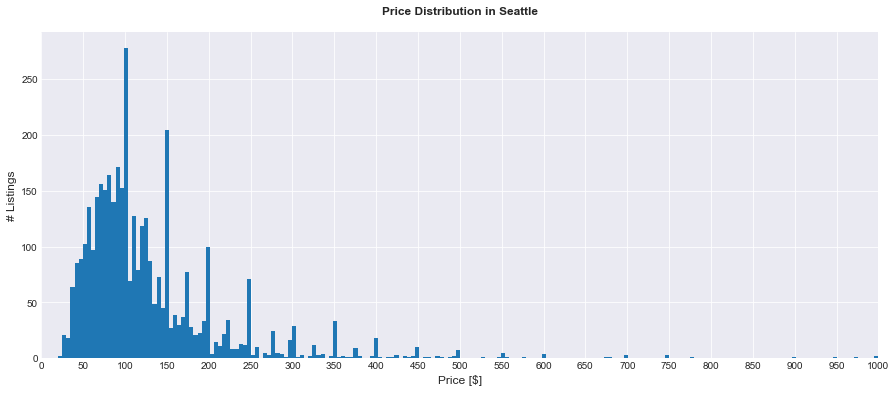

In [47]:
plt.figure(figsize=(15,6))
plt.title('Price Distribution in Seattle\n', fontweight='bold', fontsize=12)
plt.xlim(0, 1000)
plt.ylabel('# Listings', fontsize=12)
plt.xlabel('Price [$]', fontsize=12)
plt.xticks(np.arange(0, 1000+1, 50))
plt.hist(seattle_listing_df.price, bins=200)
plt.show()

In [48]:
print('Distribution Details:')
seattle_listing_df.price.describe()

Distribution Details:


count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

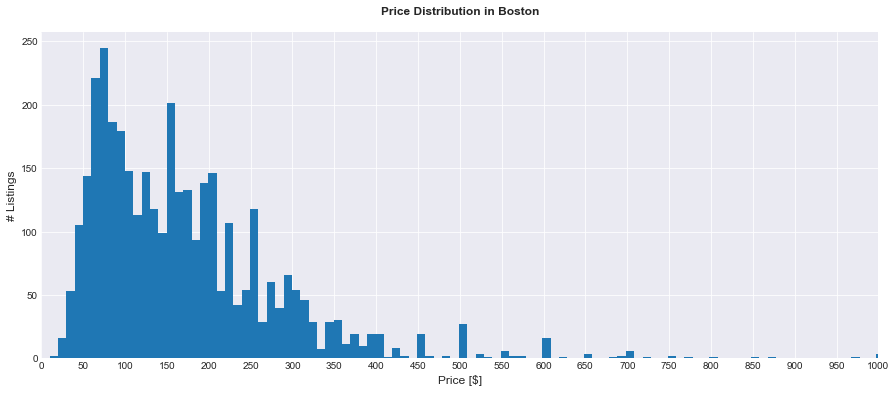

In [49]:
plt.figure(figsize=(15,6))
plt.title('Price Distribution in Boston\n', fontweight='bold', fontsize=12)
plt.xlim(0, 1000)
plt.ylabel('# Listings', fontsize=12)
plt.xlabel('Price [$]', fontsize=12)
plt.xticks(np.arange(0, 1000+1, 50))
plt.hist(boston_listing_df.price, bins=400)
plt.show()

In [50]:
print('Distribution Details:')
boston_listing_df.price.describe()

Distribution Details:


count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

#### Comparison of Price Distributions

The number of listings is similar in both cities. In the period under review there were 3,818 listings in Seattle and 3,585 listings in Boston. The average Airbnb accomodation price is by far higher in Boston (174\$) than in Seattle (128\$). The standard deviation is by far higher in Boston (std=148) than in Seattle (std=90). So the market in Boston is more differentiated. Most accomodations are offered at a round price such as 100$ as the peaks in the histograms show.

#### 4.2 Price Development over Time

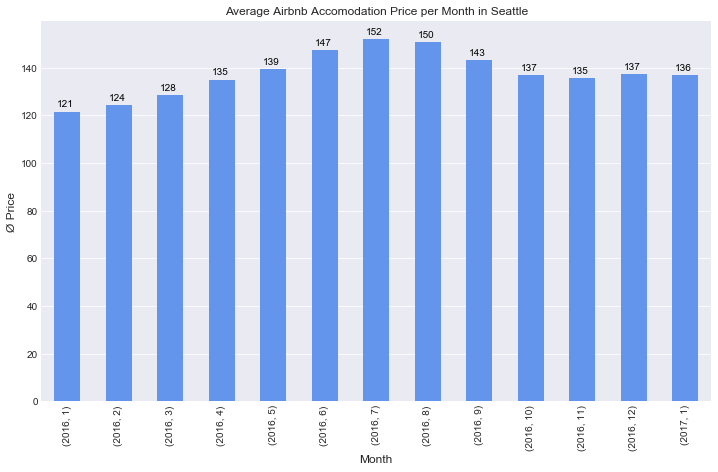

In [51]:
# Setup Plot
seattle_calendar_df.price.groupby([seattle_calendar_df['date'].dt.year, seattle_calendar_df['date'].dt.month]).mean().plot(kind='bar', color='cornflowerblue', figsize=(12,7)).xaxis.grid()
plt.title('Average Airbnb Accomodation Price per Month in Seattle')
plt.ylabel('Ø Price', fontsize=12)
plt.xlabel('Month', fontsize=12)

# Create Labels
for i in range(13):
    plt.text(x = -0.2+i, 
             y=seattle_calendar_df.price.groupby([seattle_calendar_df['date'].dt.year, seattle_calendar_df['date'].dt.month]).mean()[i]+3, 
             s=seattle_calendar_df.price.groupby([seattle_calendar_df['date'].dt.year, seattle_calendar_df['date'].dt.month]).mean().astype(int)[i], 
             color = 'black', fontsize=10, va='center')

# Show Plot
plt.show()

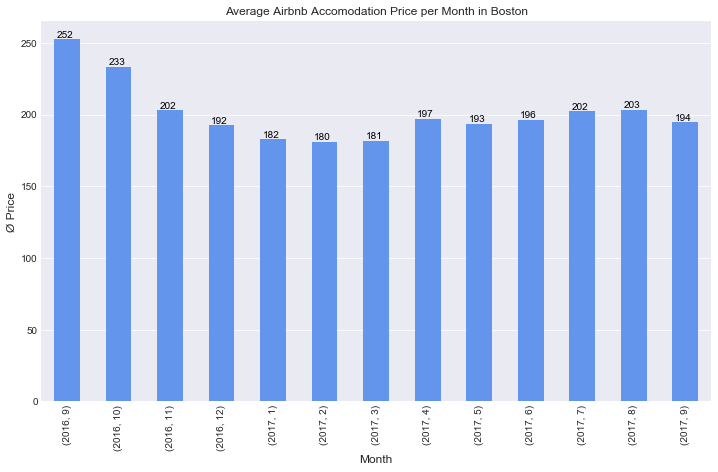

In [52]:
# Setup Plot
boston_calendar_df.price.groupby([boston_calendar_df['date'].dt.year, boston_calendar_df['date'].dt.month]).mean().plot(kind='bar', color='cornflowerblue', figsize=(12,7)).xaxis.grid()
plt.title('Average Airbnb Accomodation Price per Month in Boston')
plt.ylabel('Ø Price', fontsize=12)
plt.xlabel('Month', fontsize=12)

# Create Labels
for i in range(13):
    plt.text(x = -0.2+i, 
             y=boston_calendar_df.price.groupby([boston_calendar_df['date'].dt.year, boston_calendar_df['date'].dt.month]).mean()[i]+3, 
             s=boston_calendar_df.price.groupby([boston_calendar_df['date'].dt.year, boston_calendar_df['date'].dt.month]).mean().astype(int)[i], 
             color = 'black', fontsize=10, va='center')

# Show Plot
plt.show()

#### Price Development over Time
The average Airbnb accomodation price is subject to saisonality in both cities. It has its minimum in the winter months, January in Seattle (121\$) and February in Boston (180\$), and its maximum in the summer months: July in Seattle (152\$) and September in Boston (252\$). The average price seems to increase in Seattle and decrease in Boston. But to make an accurate statement here, a longer data period should have to be considered.

#### 4.3. Geovisualized Airbnb Accomodation Prices

In [53]:
# Setup Folium Map for Seattle
map = folium.Map(location=[47.608, -122.335], zoom_start=11)

# Mark Locations
for location in range(seattle_listing_df.shape[0]):
    
    # Color Coding based on price
    price = seattle_listing_df.price.iloc[location]   
    if price <= 100:
        col = 'green'
    elif price <= 150:
        col = 'orange'
    else: 
        col = 'red'
              
    # Draw Circlemarker for Location
    folium.CircleMarker(location=[seattle_listing_df.latitude.iloc[location], seattle_listing_df.longitude.iloc[location]], 
                        radius=2, weight=1.5, color=col, fill_color=col).add_to(map)
    
# Show Map
print('Pricing of Airbnb Accomodations in Seattle')
print('Green: <100$')
print('Orange: >100$ and =<150$')
print('Red: >150$')
map.save('geoplot_seattle_pricing.html')
from IPython.display import HTML
HTML('<iframe src=geoplot_seattle_pricing.html width=700 height=450></iframe>')

Pricing of Airbnb Accomodations in Seattle
Green: <100$
Orange: >100$ and =<150$
Red: >150$


In [54]:
# Setup Folium Map for Boston
map = folium.Map(location=[42.321, -71.057], zoom_start=11.5)

# Mark Locations
for location in range(boston_listing_df.shape[0]):
    
    # Color Coding based on price
    price = boston_listing_df.price.iloc[location]   
    if price <= 100:
        col = 'green'
    elif price <= 150:
        col = 'orange'
    else: 
        col = 'red'
              
    # Draw Circlemarker for Location
    folium.CircleMarker(location=[boston_listing_df.latitude.iloc[location], boston_listing_df.longitude.iloc[location]], 
                        radius=2, weight=1.5, color=col, fill_color=col).add_to(map)
    
# Show Map
print('Pricing of Airbnb Accomodations in Boston')
print('Green: <100$')
print('Orange: >100$ and =<150$')
print('Red: >150$')
map.save('geoplot_boston_pricing.html')
from IPython.display import HTML
HTML('<iframe src=geoplot_boston_pricing.html width=700 height=450></iframe>')

Pricing of Airbnb Accomodations in Boston
Green: <100$
Orange: >100$ and =<150$
Red: >150$


#### 4.4 Pricing per Neighbourhood

In [55]:
seattle_listing_df.price.groupby(seattle_listing_df['neighbourhood_cleansed']).mean().sort_values(ascending=False)

neighbourhood_cleansed
Southeast Magnolia           231.705882
Portage Bay                  227.857143
Westlake                     194.470588
West Queen Anne              187.769231
Montlake                     182.789474
Briarcliff                   176.571429
Sunset Hill                  176.055556
Industrial District          173.333333
Alki                         171.619048
Windermere                   169.900000
Pioneer Square               169.260870
Central Business District    164.213592
Fauntleroy                   164.100000
Belltown                     162.893162
East Queen Anne              159.414634
Madrona                      158.234043
Pike-Market                  157.785714
North Queen Anne             150.240741
Green Lake                   149.018519
Lawton Park                  147.566667
Holly Park                   147.166667
North Admiral                146.408163
View Ridge                   139.000000
Lower Queen Anne             138.202128
First Hill       

In [56]:
seattle_listing_df.price.groupby(seattle_listing_df['neighbourhood_group_cleansed']).mean().sort_values(ascending=False)

neighbourhood_group_cleansed
Magnolia               177.672131
Queen Anne             157.223729
Downtown               154.405660
West Seattle           141.359606
Cascade                140.101124
Capitol Hill           130.592593
Central Area           128.338753
Ballard                124.682609
Other neighborhoods    119.968514
Interbay               109.727273
Seward Park            108.477273
Beacon Hill             94.669492
University District     93.639344
Lake City               92.671642
Rainier Valley          91.899371
Northgate               88.550000
Delridge                83.278481
Name: price, dtype: float64

In [57]:
boston_listing_df.price.groupby(boston_listing_df['neighbourhood_cleansed']).mean().sort_values(ascending=False)

neighbourhood_cleansed
South Boston Waterfront    306.060241
Bay Village                266.833333
Leather District           253.600000
Back Bay                   240.950331
Downtown                   236.459302
Chinatown                  232.352113
Beacon Hill                224.443299
Fenway                     220.393103
West End                   209.591837
South End                  204.349693
Charlestown                198.045045
North End                  195.678322
South Boston               187.609195
Roxbury                    146.333333
Jamaica Plain              138.478134
Longwood Medical Area      138.444444
Mission Hill               121.967742
East Boston                119.153333
Brighton                   118.767568
Allston                    112.307692
West Roxbury               107.108696
Roslindale                  98.428571
Dorchester                  91.639405
Hyde Park                   86.548387
Mattapan                    75.125000
Name: price, dtype: float64

In [58]:
boston_listing_df.price.groupby(boston_listing_df['neighbourhood_group_cleansed']).mean().sort_values(ascending=False)

Series([], Name: price, dtype: float64)

Adding number of listings

In [59]:
seattle_listing_df.groupby(['neighbourhood_group_cleansed']).size().sort_values(ascending=False)

neighbourhood_group_cleansed
Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
dtype: int64

In [60]:
boston_listing_df.groupby(['neighbourhood_cleansed']).size().sort_values(ascending=False)

neighbourhood_cleansed
Jamaica Plain              343
South End                  326
Back Bay                   302
Fenway                     290
Dorchester                 269
Allston                    260
Beacon Hill                194
Brighton                   185
South Boston               174
Downtown                   172
East Boston                150
Roxbury                    144
North End                  143
Mission Hill               124
Charlestown                111
South Boston Waterfront     83
Chinatown                   71
Roslindale                  56
West End                    49
West Roxbury                46
Hyde Park                   31
Bay Village                 24
Mattapan                    24
Longwood Medical Area        9
Leather District             5
dtype: int64

In [61]:
# Seattle
neigh_prices_seattle = seattle_listing_df.price.groupby(seattle_listing_df['neighbourhood_group_cleansed']).mean().sort_values(ascending=False)
neig_listings_seattle = seattle_listing_df.groupby(['neighbourhood_group_cleansed']).size().sort_values(ascending=False)
neigh_data_seattle = pd.concat([neig_listings_seattle,neigh_prices_seattle], axis=1)
neigh_data_seattle.rename(columns={0: '# Listings'}, inplace=True)
neigh_data_seattle.sort_values('price', ascending=False)

,# Listings,price
Magnolia,61,177.672131
Queen Anne,295,157.223729
Downtown,530,154.405660
West Seattle,203,141.359606
Cascade,89,140.101124
Capitol Hill,567,130.592593
Central Area,369,128.338753
Ballard,230,124.682609
Other neighborhoods,794,119.968514
Interbay,11,109.727273


In [62]:
# Boston
neigh_prices_boston = boston_listing_df.price.groupby(boston_listing_df['neighbourhood_cleansed']).mean().sort_values(ascending=False)
neig_listings_boston = boston_listing_df.groupby(['neighbourhood_cleansed']).size().sort_values(ascending=False)
neigh_data_boston = pd.concat([neig_listings_boston,neigh_prices_boston], axis=1)
neigh_data_boston.rename(columns={0: '# Listings'}, inplace=True)
neigh_data_boston.sort_values('price', ascending=False)

,# Listings,price
South Boston Waterfront,83,306.060241
Bay Village,24,266.833333
Leather District,5,253.600000
Back Bay,302,240.950331
Downtown,172,236.459302
Chinatown,71,232.352113
Beacon Hill,194,224.443299
Fenway,290,220.393103
West End,49,209.591837
South End,326,204.349693


#### Comparison of Regional Pricing in Seattle and Boston
A noticeable effect is that the prices rise the closer the accommodation is to the city center. In the plots, this becomes especially apparent in the case of Boston. In Boston's dataset the feature 'neighbourhood_cleansed' seems to be on the same aggregation level as 'neighbourhood_group_cleansed' in Seattle's dataset. When comparing the average price range of the neigbourhoods in both cities, the higher price differentiation of Boston's market becomes clear, again. Even though the average Airbnb accomodation prices are by far higher in Boston, there are neighbourhoods with significantly lower average prices than in Seattle.

In Seattle most listings are located in the central neighbourhoods (Queen Anne, Downtown, Capitol Hill, Cascade, Ballard and Central Area) and in West Seattle. These accomodations are offered within the average price range 120\$ - 157\$ (other neighbourhoods not taken into account). Higher prices are only taken in Magnolia, which is a peninsula in the northwest of Seattle, next to Discovery Park. In Boston the distribution of listings is not that centralized. There are many accomodations offered in less centrally located neighbourhoods such as Dorchester and Jamaica Plain. The highest prices are taken in centrally located neighbourhoods such as Waterfront, Bay Village, Black Bay and Downtown.

### 5. Analysis of Review Data

#### 5.1 Number of Reviews over Time

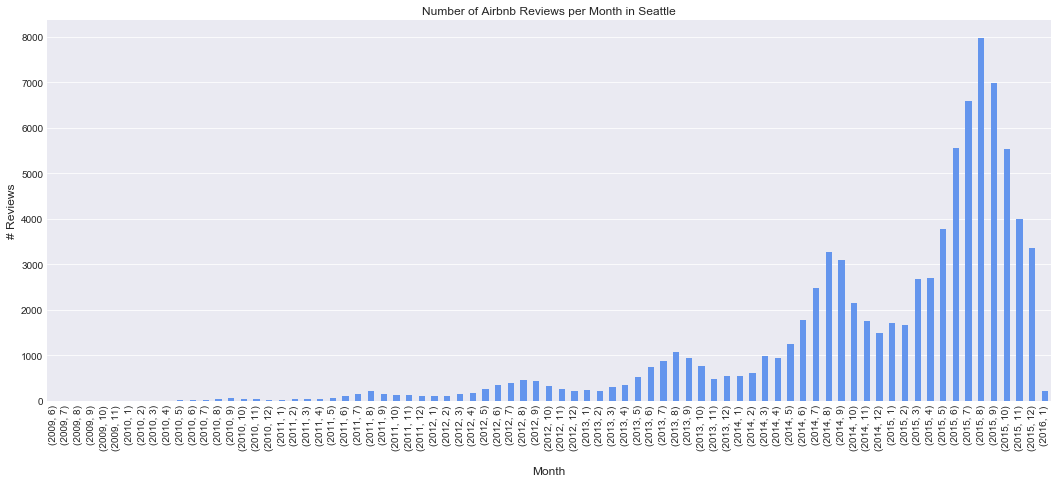

In [63]:
# Setup Plot
seattle_reviews_df.listing_id.groupby([seattle_reviews_df['date'].dt.year, seattle_reviews_df['date'].dt.month]).count().plot(kind='bar', color='cornflowerblue', figsize=(18,7)).xaxis.grid()
plt.title('Number of Airbnb Reviews per Month in Seattle')
plt.ylabel('# Reviews', fontsize=12)
plt.xlabel('\nMonth', fontsize=12)

# Show Plot
plt.show()

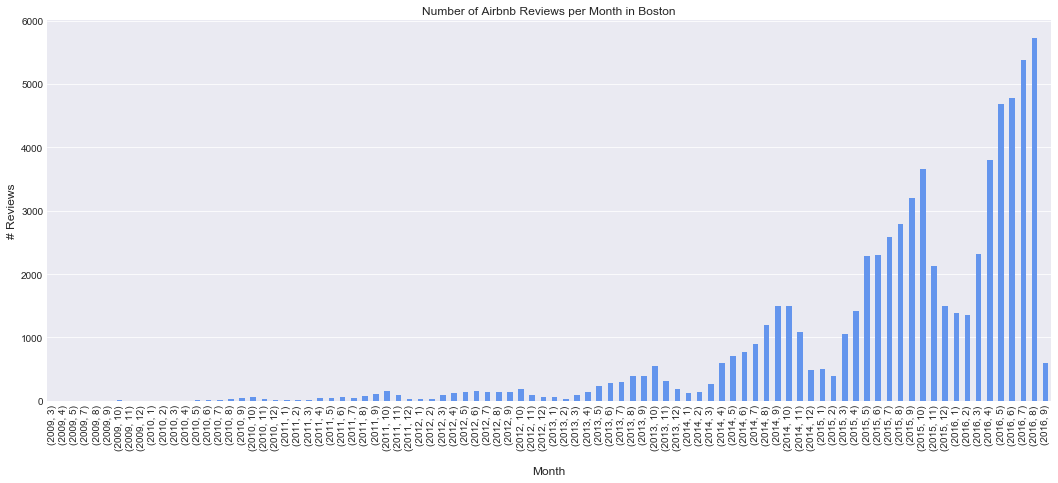

In [64]:
# Setup Plot
boston_reviews_df.listing_id.groupby([boston_reviews_df['date'].dt.year, boston_reviews_df['date'].dt.month]).count().plot(kind='bar', color='cornflowerblue', figsize=(18,7)).xaxis.grid()
plt.title('Number of Airbnb Reviews per Month in Boston')
plt.ylabel('# Reviews', fontsize=12)
plt.xlabel('\nMonth', fontsize=12)

# Show Plot
plt.show()

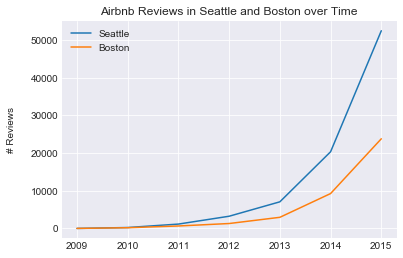

In [65]:
# calculation of market growth per year
seattle_no_reviews = seattle_reviews_df.listing_id.groupby([seattle_reviews_df['date'].dt.year]).count()
boston_no_reviews = boston_reviews_df.listing_id.groupby([boston_reviews_df['date'].dt.year]).count()

# Remove year 2016, because it is not completly collected in caase of Seattle
seattle_no_reviews.drop(2016, axis=0, inplace=True)
boston_no_reviews.drop(2016, axis=0, inplace=True)

# Calculate market growths
seattle_review = plt.plot(seattle_no_reviews)
boston_reviews = plt.plot(boston_no_reviews)
plt.title('Airbnb Reviews in Seattle and Boston over Time')
plt.ylabel('# Reviews\n')
plt.legend(['Seattle','Boston'])
plt.show()

#### Reviews over Time
The number of ratings and thus the number of bookings increases rapidly over time in Seattle and Boston. The market growth increases exponentially in both cities, whereby the groth curve is steeper for Seattle. The seasonality seen in the price development over time is also apparent in the plots above. Similar to the pricing, the number of reviews reaches its minimum in the winter months and its maximum in the summer months, which makes the linkage between pricing and demand very clear.

#### 5.3. Review Texts

Seattle's Airbnb Reviews


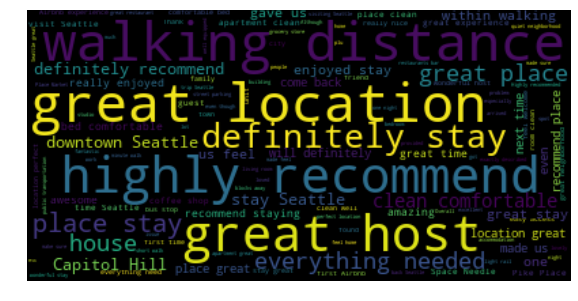

In [66]:
# Seattle's Review text Data
print('Seattle\'s Airbnb Reviews')

# Get text of all Review Comments
text = " ".join(str(review) for review in seattle_reviews_df.comments)

# Remove Stopwords
stopwords = set(STOPWORDS)
stopwords.update(['house', 'place', 'flat', 'walk', 'stay', 'host'])

# Create & Generate a Wordcloud
wordcloud = WordCloud().generate(text)

# Display Wordcloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Boston's Airbnb Reviews


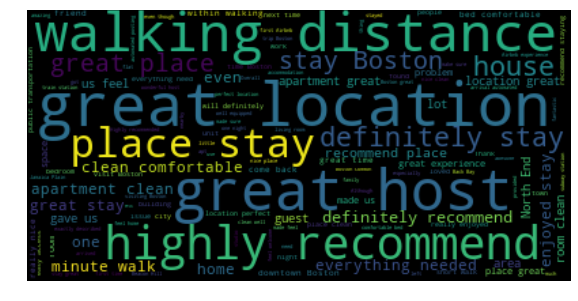

In [67]:
# Boston's Review Text Data
print('Boston\'s Airbnb Reviews')

# Get text of all Review Comments
text = " ".join(str(review) for review in boston_reviews_df.comments)

# Remove Stopwords
stopwords = set(STOPWORDS)
stopwords.update(['house', 'place', 'flat', 'walk', 'stay', 'host'])

# Create & Generate a Wordcloud
wordcloud = WordCloud().generate(text)

# Display Wordcloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Comparison of Review Texts
The Wordclouds show that the reviews are very positive for both cities.

#### 5.4. Analysis of Review Scores

In [68]:
print('Seattle\'s Review Scores:\n')
print('Accuracy: ' + str(seattle_listing_df.review_scores_accuracy.mean())[:4])
print('Checkin: ' + str(seattle_listing_df.review_scores_checkin.mean())[:4])
print('Cleanliness: ' + str(seattle_listing_df.review_scores_cleanliness.mean())[:4])
print('Communication: ' + str(seattle_listing_df.review_scores_communication.mean())[:4])
print('Location: ' + str(seattle_listing_df.review_scores_location.mean())[:4])
print('Rating: ' + str(seattle_listing_df.review_scores_rating.mean())[:4])
print('Value: ' + str(seattle_listing_df.review_scores_value.mean())[:4])

Seattle's Review Scores:

Accuracy: 9.63
Checkin: 9.78
Cleanliness: 9.55
Communication: 9.80
Location: 9.60
Rating: 94.5
Value: 9.45


In [69]:
print('Boston\'s Review Scores:\n')
print('Accuracy: ' + str(boston_listing_df.review_scores_accuracy.mean())[:4])
print('Checkin: ' + str(boston_listing_df.review_scores_checkin.mean())[:4])
print('Cleanliness: ' + str(boston_listing_df.review_scores_cleanliness.mean())[:4])
print('Communication: ' + str(boston_listing_df.review_scores_communication.mean())[:4])
print('Location: ' + str(boston_listing_df.review_scores_location.mean())[:4])
print('Rating: ' + str(boston_listing_df.review_scores_rating.mean())[:4])
print('Value: ' + str(boston_listing_df.review_scores_value.mean())[:4])

Boston's Review Scores:

Accuracy: 9.43
Checkin: 9.64
Cleanliness: 9.25
Communication: 9.64
Location: 9.41
Rating: 91.9
Value: 9.16


In [70]:
# Setup Folium Map for Seattle - Rating
map = folium.Map(location=[47.608, -122.335], zoom_start=11)

# Mark Locations
for location in range(seattle_listing_df.shape[0]):
    
    # Color Coding based on price
    rating = seattle_listing_df.review_scores_rating.iloc[location]   
    if rating < 80:
        col = 'red'
    elif rating < 95:
        col = 'orange'
    else: 
        col = 'green'
              
    # Draw Circlemarker for Location
    folium.CircleMarker(location=[seattle_listing_df.latitude.iloc[location], seattle_listing_df.longitude.iloc[location]], 
                        radius=2, weight=1.5, color=col, fill_color=col).add_to(map)
    
# Show Map
print('Rating of Airbnb Accomodations in Seattle')
print('Red: <80')
print('Orange: >=80 and <95')
print('Green: <=95')
map.save('geoplot_seattle_rating.html')
from IPython.display import HTML
HTML('<iframe src=geoplot_seattle_rating.html width=700 height=450></iframe>')

Rating of Airbnb Accomodations in Seattle
Red: <80
Orange: >=80 and <95
Green: <=95


In [71]:
# Setup Folium Map for Boston - Rating
map = folium.Map(location=[42.321, -71.057], zoom_start=11.5)

# Mark Locations
for location in range(boston_listing_df.shape[0]):
    
    # Color Coding based on price
    rating = boston_listing_df.review_scores_rating.iloc[location]   
    if rating < 80:
        col = 'red'
    elif rating < 95:
        col = 'orange'
    else: 
        col = 'green'
              
    # Draw Circlemarker for Location
    folium.CircleMarker(location=[boston_listing_df.latitude.iloc[location], boston_listing_df.longitude.iloc[location]], 
                        radius=2, weight=1.5, color=col, fill_color=col).add_to(map)
    
# Show Map
print('Rating of Airbnb Accomodations in Boston')
print('Red: <80')
print('Orange: >=80 and <95')
print('Green: <=95')
map.save('geoplot_boston_rating.html')
from IPython.display import HTML
HTML('<iframe src=geoplot_boston_rating.html width=700 height=450></iframe>')

Rating of Airbnb Accomodations in Boston
Red: <80
Orange: >=80 and <95
Green: <=95


#### Comparison of Review Scores
The review scores confirm the impression gained from the wordclouds. The scores are quite high for both cities. But it can also be seen that Seattle is outperforming Boston in every category. The distribution of ratings across the city shows some spots where negative ratings accumulate in case of both cities. In Seattle you can see an accumulation of lower ratings in the University district. In Boston there are accumulations of lower ratings in Dorchester, Fenway, Allston, East Boston and at JFK/UMass station.

### 6. Correlation Matrix for Listing Data

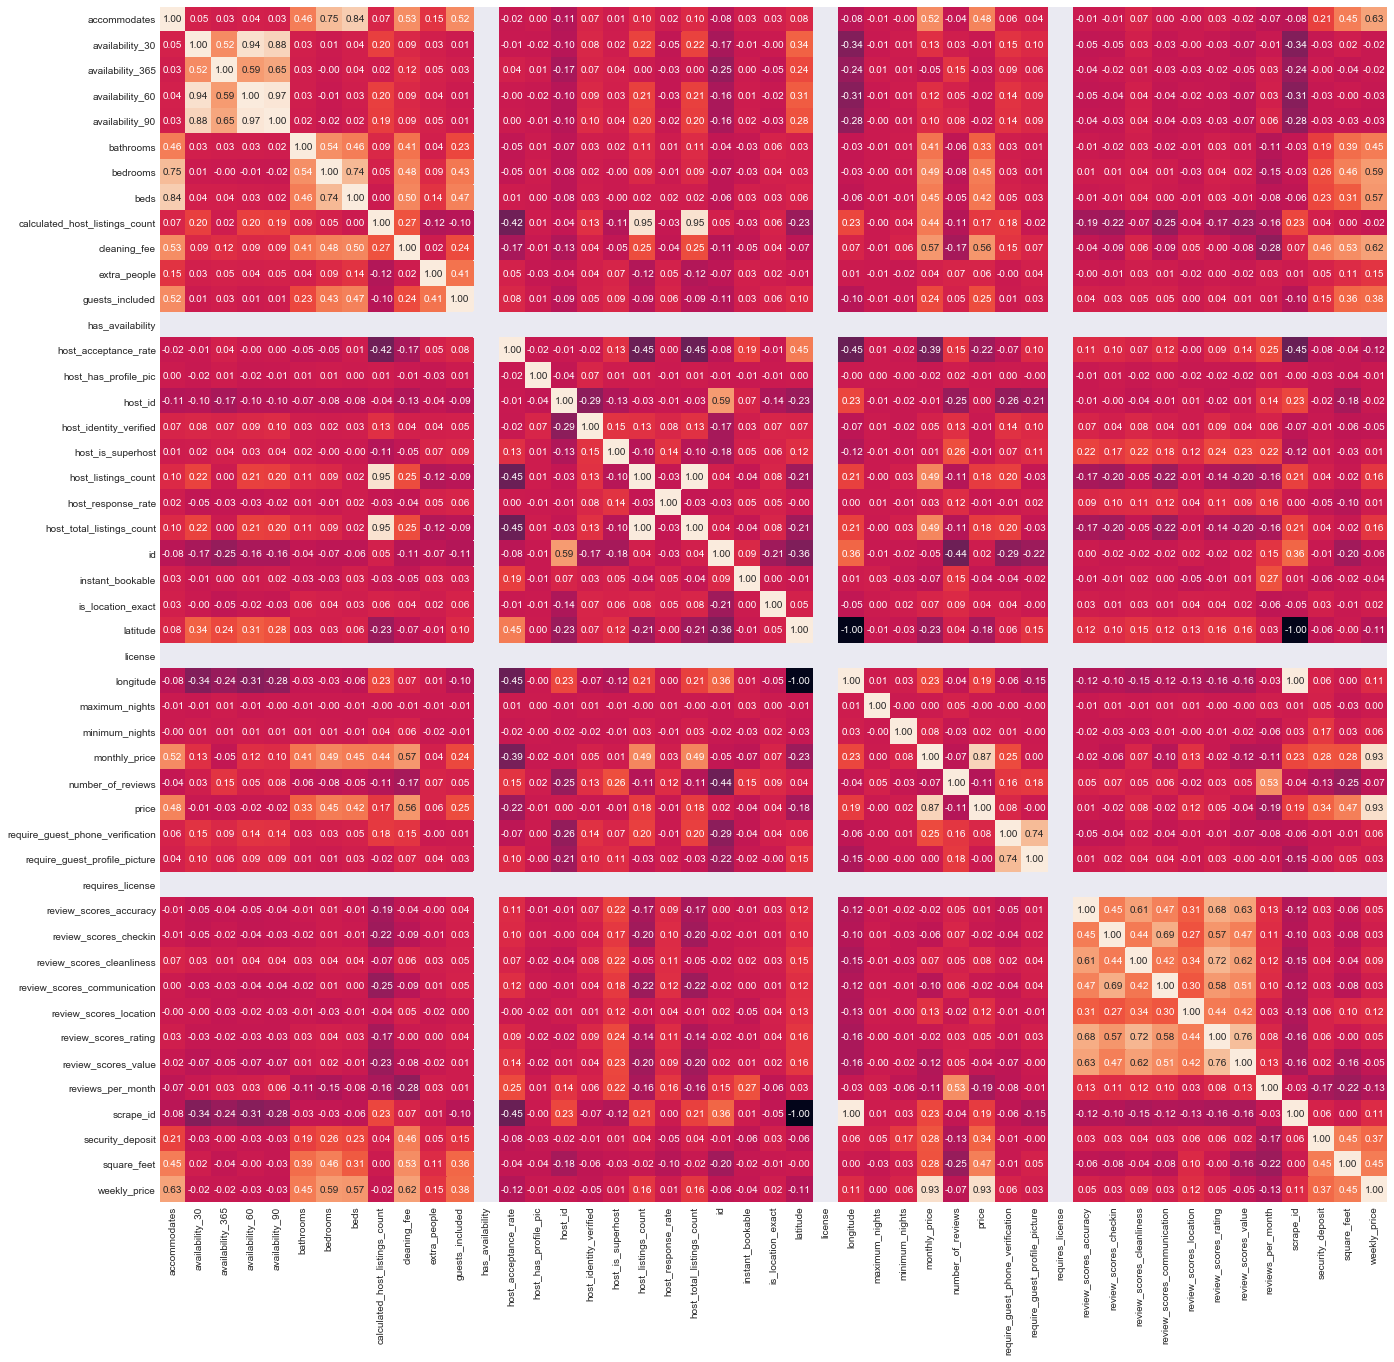

In [72]:
sns.set_style("darkgrid")
plt.figure(figsize=(22,22))
sns.heatmap(listing_df.corr(), annot = True, fmt = '.2f', cbar=False)
plt.show()

The correlation matrix shows that there are redundancies in the data. In the next step, these will be removed.

## II. Data Preparation

### 1. Removal of redundant data

In [73]:
print('The information content of "neighbourhood" is contained in "neighbourhood_cleansed".')
listing_df.drop('neighbourhood', axis=1, inplace=True)
print('The information content of "scrape_id" is contained in "longitude" and "latitude".')
listing_df.drop('scrape_id', axis=1, inplace=True)
print('The information content of "weekly_price" is almost completely contained in "price".')
listing_df.drop('weekly_price', axis=1, inplace=True)
print('The information content of "monthly_price" is almost completely contained in "price".')
listing_df.drop('monthly_price', axis=1, inplace=True)
print('The information content of "host_listings_count" is almost completely contained in "calculated_host_listings_count".')
listing_df.drop('host_listings_count', axis=1, inplace=True)
print('The information content of "host_total_listings_count" is almost completely contained in "calculated_host_listings_count".')
listing_df.drop('host_total_listings_count', axis=1, inplace=True)
print('The information content of "availability_60" and "availability_90" is almost completely contained in "availability_30".')
listing_df.drop('availability_60', axis=1, inplace=True)
listing_df.drop('availability_90', axis=1, inplace=True)

The information content of "neighbourhood" is contained in "neighbourhood_cleansed".
The information content of "scrape_id" is contained in "longitude" and "latitude".
The information content of "weekly_price" is almost completely contained in "price".
The information content of "monthly_price" is almost completely contained in "price".
The information content of "host_listings_count" is almost completely contained in "calculated_host_listings_count".
The information content of "host_total_listings_count" is almost completely contained in "calculated_host_listings_count".
The information content of "availability_60" and "availability_90" is almost completely contained in "availability_30".


### 2. Handling of Missing Data

#### 2.1. Calendar Data

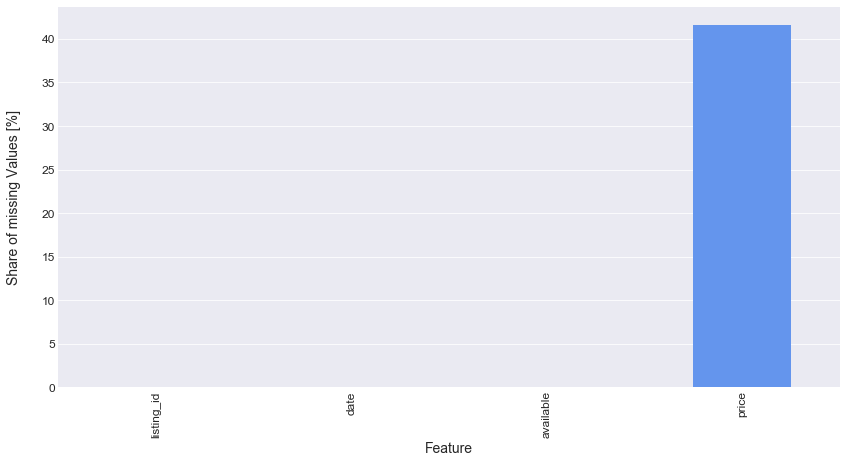

In [74]:
# Share of Missing Values
sns.set_style("darkgrid")
((calendar_df.isnull().sum() / calendar_df.shape[0]) * 100).sort_values().plot.bar(figsize=(14,7), color='cornflowerblue', fontsize=12).xaxis.grid() 
plt.ylabel('Share of missing Values [%]\n', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.show()

Feature 'price' has >=40% missing values. But I will not exclude it form the dataset, because it could be of interest in the further analysis.

#### 2.2. Review Data

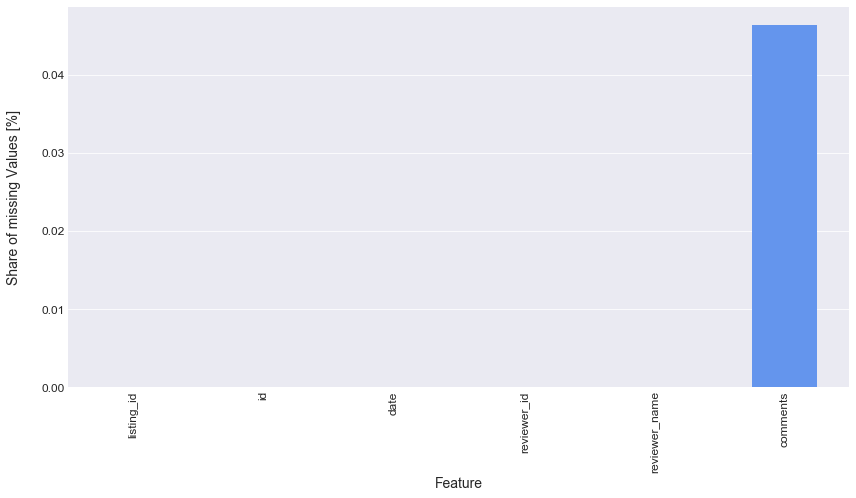

In [75]:
# Share of Missing Values
((reviews_df.isnull().sum() / reviews_df.shape[0]) *100).sort_values().plot.bar(figsize=(14,7), color='cornflowerblue', fontsize=12).xaxis.grid()
plt.ylabel('Share of missing Values [%]\n', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.show()

In the review data there is no need to exclude columns from the dataset.

#### 2.3. Listing Data

##### a. Missing Column Data

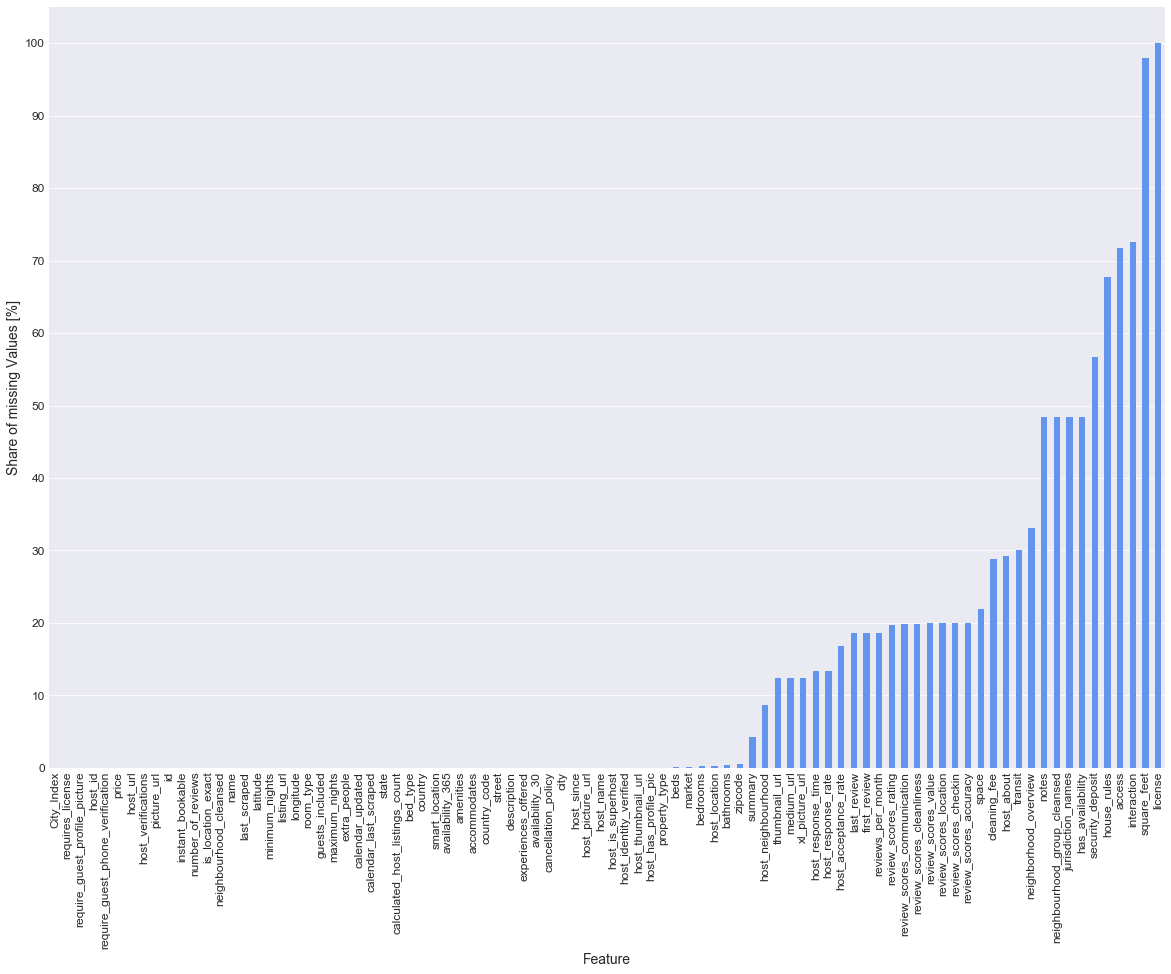

In [76]:
# Share of Missing Values
((listing_df.isnull().sum() / listing_df.shape[0]) *100).sort_values().plot.bar(figsize=(20,14), color='cornflowerblue', fontsize=12).xaxis.grid()
plt.ylabel('Share of missing Values [%]', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.yticks(np.arange(0, 100+1, 10))
plt.show()

Removal of columns with >=30% missing values. Feature 'neighbourhood_group_cleansed' remains excluded from this, because it could be of interest in the further analysis.

In [77]:
# Removal of columns with >=30% missing values
listing_df.drop('license', axis=1, inplace=True)
listing_df.drop('square_feet', axis=1, inplace=True)
listing_df.drop('interaction', axis=1, inplace=True)
listing_df.drop('access', axis=1, inplace=True)
listing_df.drop('house_rules', axis=1, inplace=True)
#listing_df.drop('monthly_price', axis=1, inplace=True) --> Feature has already been deleted due to redundancy
#listing_df.drop('weekly_price', axis=1, inplace=True) --> Feature has already been deleted due to redundancy
listing_df.drop('security_deposit', axis=1, inplace=True)
listing_df.drop('has_availability', axis=1, inplace=True)
listing_df.drop('jurisdiction_names', axis=1, inplace=True)
listing_df.drop('notes', axis=1, inplace=True)
listing_df.drop('transit', axis=1, inplace=True)

##### b. Missing Labels (Feature 'price')

In [78]:
print('Number of rows with missing labels: ' + str(listing_df.price.isna().sum()))

Number of rows with missing labels: 0


The listing dataset does not contain rows with missing labels.

##### c. Missing Row Data

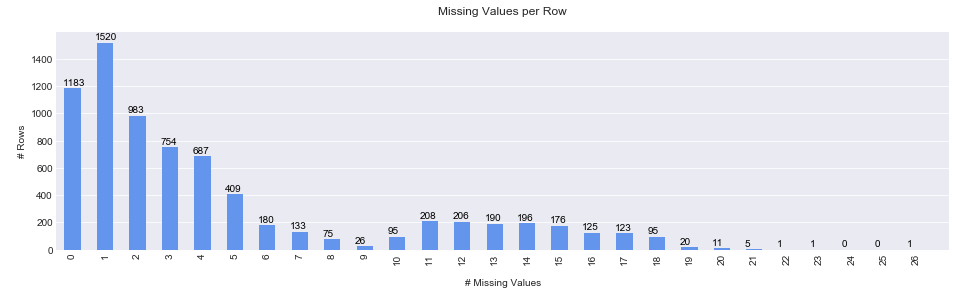

In [79]:
# How much data is missing in each row of the dataset?
listing_df_missing_row_data = listing_df.isnull().sum(axis=1)
listing_df_missing_row_data = listing_df_missing_row_data.value_counts()
listing_df_missing_row_data.loc[24] = 0
listing_df_missing_row_data.loc[25] = 0
listing_df_missing_row_data = listing_df_missing_row_data.sort_index()

# Create Plot
plt.figure(figsize=(16,4))
listing_df_missing_row_data.plot.bar(color='cornflowerblue').xaxis.grid()
plt.title('Missing Values per Row\n')
plt.ylabel('\n# Rows')
plt.xticks(np.arange(0, 27+1, 1))
plt.xlabel('\n# Missing Values')

# Create Labels
for i in range(27):
            plt.text(x = -0.3+i, 
                 y=listing_df_missing_row_data[i]+40, 
                 s=listing_df_missing_row_data[i], 
                 color = 'black', fontsize=10, va='center')

# Show Plot
plt.show()

In [80]:
# Removal of rows with >=19 missing values
listing_df = listing_df[listing_df.isnull().sum(axis=1) < 19]
# Check
listing_df.shape

(7364, 78)

### 3. Removal of columns not needed for Machine Learning Algorithm

In [81]:
listing_df.drop(['calendar_updated'], axis=1, inplace=True)
listing_df.drop(['calendar_last_scraped'], axis=1, inplace=True)
listing_df.drop(['country'], axis=1, inplace=True)
listing_df.drop(['country_code'], axis=1, inplace=True)
listing_df.drop(['description'], axis=1, inplace=True)
listing_df.drop(['host_since'], axis=1, inplace=True)
listing_df.drop(['host_about'], axis=1, inplace=True)
listing_df.drop(['host_id'], axis=1, inplace=True)
listing_df.drop(['host_location'], axis=1, inplace=True)
listing_df.drop(['host_name'], axis=1, inplace=True)
listing_df.drop(['host_picture_url'], axis=1, inplace=True)
listing_df.drop(['host_thumbnail_url'], axis=1, inplace=True)
listing_df.drop(['host_url'], axis=1, inplace=True)
listing_df.drop(['host_verifications'], axis=1, inplace=True)
listing_df.drop(['last_review'], axis=1, inplace=True)
listing_df.drop(['last_scraped'], axis=1, inplace=True)
listing_df.drop(['listing_url'], axis=1, inplace=True)
listing_df.drop(['latitude'], axis=1, inplace=True)
listing_df.drop(['longitude'], axis=1, inplace=True)
listing_df.drop(['market'], axis=1, inplace=True)
listing_df.drop(['medium_url'], axis=1, inplace=True)
listing_df.drop(['name'], axis=1, inplace=True)
listing_df.drop(['neighborhood_overview'], axis=1, inplace=True)
listing_df.drop(['picture_url'], axis=1, inplace=True)
listing_df.drop(['smart_location'], axis=1, inplace=True)
listing_df.drop(['space'], axis=1, inplace=True)
listing_df.drop(['state'], axis=1, inplace=True)
listing_df.drop(['street'], axis=1, inplace=True)
listing_df.drop(['summary'], axis=1, inplace=True)
listing_df.drop(['thumbnail_url'], axis=1, inplace=True)
listing_df.drop(['xl_picture_url'], axis=1, inplace=True)
listing_df.drop(['experiences_offered'], axis=1, inplace=True)
listing_df.drop(['first_review'], axis=1, inplace=True)
listing_df.drop(['id'], axis=1, inplace=True)
listing_df.drop(['city'], axis=1, inplace=True)

### 4. One Hot Encoding

In [82]:
# One Hot Encoding of categorical features
listing_df = pd.get_dummies(listing_df, columns=['bed_type','cancellation_policy','host_response_time','property_type','room_type', 'host_neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','zipcode'])

In [83]:
# Feature 'amenities' needs special handling
listing_df.amenities.head()

0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
5    {"Wireless Internet","Free Parking on Premises...
Name: amenities, dtype: object

In [84]:
# Fill null values
listing_df.amenities.fillna("null")

# List with all amenities
amenities_list = []
for amenity in (listing_df.amenities):
    amenities_list.append([amenity.replace("{","").replace("}","").replace('"','').split(",")])

# Set with all amenities
amenity_set = []
for amenities in amenities_list:
    for amenity in amenities[0]:
        amenity_set.append(amenity)

# Cleaned list with all amenities
amenity_names = list(set(amenity_set))

# Edit names
amenity_names_list = []
for amenity_name in amenity_names:
    amenity_names_list.append("amenities " + amenity_name) 
    names = "amenities " + amenity_name

In [85]:
# Introduce an amenity score
amenity_total_score = []
amenity_score = []

for amenities in amenities_list:
    amenity_score = []
    for amenity_name in amenity_names:
        score = []
        for amenity in amenities[0]:
            if amenity == amenity_name:
                score.append(1)
        if len(score) < 1:
            score.append(0)
        amenity_score.append(score[0])
        
    amenity_total_score.append(amenity_score)
    
# Append to data
df_amenities = pd.DataFrame(data = amenity_total_score,columns = amenity_names_list,  index = listing_df.index)
df_preprocessed = pd.concat([listing_df,df_amenities], axis=1)

In [86]:
# Delete original amenities column and further columns
df_preprocessed.drop('amenities', axis=1, inplace=True)
df_preprocessed.drop('amenities ', axis=1, inplace=True)
df_preprocessed.drop('amenities translation missing: en.hosting_amenity_49', axis=1, inplace=True)
df_preprocessed.drop('amenities translation missing: en.hosting_amenity_50', axis=1, inplace=True)
df_preprocessed.drop('zipcode_02108 02111', axis=1, inplace=True)
df_preprocessed.drop('zipcode_02134-1704', axis=1, inplace=True)
df_preprocessed.drop('zipcode_99\n98122', axis=1, inplace=True)

In [87]:
df_preprocessed.columns.tolist()

['City_Index',
 'accommodates',
 'availability_30',
 'availability_365',
 'bathrooms',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'cleaning_fee',
 'extra_people',
 'guests_included',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_is_superhost',
 'host_response_rate',
 'instant_bookable',
 'is_location_exact',
 'maximum_nights',
 'minimum_nights',
 'number_of_reviews',
 'price',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'requires_license',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month',
 'bed_type_Airbed',
 'bed_type_Couch',
 'bed_type_Futon',
 'bed_type_Pull-out Sofa',
 'bed_type_Real Bed',
 'cancellation_policy_flexible',
 'cancellation_policy_moderate',
 'cancellation_policy_strict',
 'cancellation_policy_super_strict_30',
 'host_response_ti

In [88]:
df_preprocessed.shape

(7364, 458)

In [89]:
# Drop rows with NaN values
df_preprocessed = df_preprocessed.dropna(axis=0, how='any')

# Check amount of kept data
df_preprocessed.shape

(3883, 458)

### 4. Normalization

In [90]:
# Normalization of numerical features
numerical_features = [
     'host_response_rate',
     'host_acceptance_rate',
     'calculated_host_listings_count',
     'accommodates',
     'bathrooms',
     'bedrooms',
     'beds',
     'cleaning_fee',
     'guests_included',
     'extra_people',
     'minimum_nights',
     'maximum_nights',
     'availability_30',
     'availability_365',
     'number_of_reviews',
     'review_scores_rating',
     'review_scores_accuracy',
     'review_scores_cleanliness',
     'review_scores_checkin',
     'review_scores_communication',
     'review_scores_location',
     'review_scores_value',
     'reviews_per_month']

In [91]:
scaler = MinMaxScaler(feature_range = (0,1))
features_normalized = df_preprocessed.copy(deep = True)

features_normalized[numerical_features] = scaler.fit_transform(df_preprocessed[numerical_features])
features_normalized.head()

,City_Index,accommodates,availability_30,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,cleaning_fee,extra_people,...,amenities Gym,amenities Cat(s),amenities Elevator in Building,amenities Doorman,amenities Hot Tub,amenities Smoke Detector,amenities Other pet(s),amenities Iron,amenities Family/Kid Friendly,amenities Safety Card
1,Seattle,0.200000,0.433333,0.797260,0.222222,0.142857,0.066667,0.037037,0.118644,0.000000,...,0,0,0,0,0,1,0,0,1,1
2,Seattle,0.666667,0.033333,0.602740,1.000000,0.714286,0.466667,0.007407,1.000000,0.083333,...,0,1,0,0,1,1,0,0,1,0
7,Seattle,0.066667,0.733333,0.273973,0.222222,0.142857,0.066667,0.029630,0.067797,0.000000,...,0,0,0,0,0,0,0,0,1,0
9,Seattle,0.200000,0.200000,0.887671,0.222222,0.142857,0.066667,0.037037,0.118644,0.000000,...,0,0,0,0,0,1,0,0,1,1
10,Seattle,0.066667,0.000000,0.419178,0.222222,0.142857,0.066667,0.000000,0.033898,0.050000,...,0,0,0,0,0,1,0,1,0,1


### 5. City-based Splitting of Preprocessed Data

In [92]:
# Split data based on City Index
df_preprocessed = features_normalized.copy(deep=True)
df_preprocessed_seattle = df_preprocessed[df_preprocessed['City_Index'] == 'Seattle'].copy(deep=True)
df_preprocessed_seattle.drop('City_Index', axis=1, inplace=True)
df_preprocessed_boston =df_preprocessed[df_preprocessed['City_Index'] == 'Boston'].copy(deep=True)
df_preprocessed_boston.drop('City_Index', axis=1, inplace=True)

print('Shape of preprocessed holistic data: ' + str(df_preprocessed.shape))
print('Shape of preprocessed Seattle data: ' + str(df_preprocessed_seattle.shape))
print('Shape of preprocessed Boston data: ' + str(df_preprocessed_boston.shape))

Shape of preprocessed holistic data: (3883, 458)
Shape of preprocessed Seattle data: (2042, 457)
Shape of preprocessed Boston data: (1841, 457)


## III. Modeling

### 1. Setup Training Pipeline

In [93]:
def model_training_pipeline(model, df_preprocessed, estimators):
    '''
    Trains a given model based on a given dataset with da given number of estimators
    
    Parameters:
    - model 
    - df_preprocessed: dataset containing features and labels
    - estimators: list with number of estimators
    '''
    
    # Separate Features and Labels
    print('Separate features (X) and labels (y)...')
    y = df_preprocessed['price']
    X = df_preprocessed.copy(deep=True)
    X.drop(columns=['price'], inplace=True)
    
    # Split dataset
    print('Split data into training set & test set...')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    r2_values = []
    rmse_values = []

    # Build model fo all estimators and run it
    for estimator in estimators:
    
        # Set parameters
        model.set_params(n_estimators=estimator)
    
        # Fit model
        model.fit(X_train, y_train)
    
        # predict
        y_pred = model.predict(X_test)
    
        # Metrics
        r2 = r2_score(y_test, y_pred)
        r2_values.append(r2)
        rmse = sqrt(mean_squared_error(y_test,y_pred))
        rmse_values.append(rmse)
    
        print('-----------------------------')
        print('Model with ' + str(estimator) + ' estimators:')
        print('R2 value: ' + str(r2)[0:5] + ', RMSE: ' + str(rmse)[0:5])
    
    # Plot  scores
    plt.title('R2 Scores')
    plt.xlabel('# Estimators')
    plt.ylabel('score')
    plt.plot(estimators, r2_values)
    #plt.yticks(np.arange(0.2,0.8,0.1))
    plt.show()
    
    return model, X_test, y_test

### 2. Setup Model

In [94]:
# Setup model

# RandomForest
model_rf_seattle = RandomForestRegressor(n_jobs=-1, random_state=42)
model_rf_boston = RandomForestRegressor(n_jobs=-1, random_state=42)

# AdaBoostRegressor
model_ada_seattle = AdaBoostRegressor(random_state=42)
model_ada_boston = AdaBoostRegressor(random_state=42)

# GradientBoostingRegressor
model_grad_seattle = GradientBoostingRegressor(random_state=42)
model_grad_boston = GradientBoostingRegressor(random_state=42)

# Set Parameters:
estimators = np.arange(50,1001,50)

## IV. Evaluation

### 1. Run Training Pipeline

#### 1.1. RandomForest Regressor

Setup Model and run Training Pipeline on Seattle Data

Separate features (X) and labels (y)...
Split data into training set & test set...
-----------------------------
Model with 50 estimators:
R2 value: 0.555, RMSE: 63.71
-----------------------------
Model with 100 estimators:
R2 value: 0.556, RMSE: 63.61
-----------------------------
Model with 150 estimators:
R2 value: 0.563, RMSE: 63.12
-----------------------------
Model with 200 estimators:
R2 value: 0.564, RMSE: 63.00
-----------------------------
Model with 250 estimators:
R2 value: 0.567, RMSE: 62.80
-----------------------------
Model with 300 estimators:
R2 value: 0.567, RMSE: 62.82
-----------------------------
Model with 350 estimators:
R2 value: 0.566, RMSE: 62.89
-----------------------------
Model with 400 estimators:
R2 value: 0.566, RMSE: 62.90
-----------------------------
Model with 450 estimators:
R2 value: 0.568, RMSE: 62.76
-----------------------------
Model with 500 estimators:
R2 value: 0.568, RMSE: 62.74
---

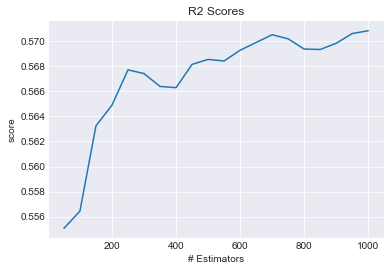

In [95]:
# Seattle
print('Setup Model and run Training Pipeline on Seattle Data\n')
model_seattle, X_test_seattle, y_test_seattle = model_training_pipeline(model_rf_seattle, df_preprocessed_seattle, estimators)

Setup Model and Run Training Pipeline on Boston Data

Separate features (X) and labels (y)...
Split data into training set & test set...
-----------------------------
Model with 50 estimators:
R2 value: 0.675, RMSE: 60.37
-----------------------------
Model with 100 estimators:
R2 value: 0.673, RMSE: 60.51
-----------------------------
Model with 150 estimators:
R2 value: 0.673, RMSE: 60.48
-----------------------------
Model with 200 estimators:
R2 value: 0.678, RMSE: 60.03
-----------------------------
Model with 250 estimators:
R2 value: 0.677, RMSE: 60.13
-----------------------------
Model with 300 estimators:
R2 value: 0.678, RMSE: 60.05
-----------------------------
Model with 350 estimators:
R2 value: 0.679, RMSE: 59.97
-----------------------------
Model with 400 estimators:
R2 value: 0.681, RMSE: 59.76
-----------------------------
Model with 450 estimators:
R2 value: 0.681, RMSE: 59.81
-----------------------------
Model with 500 estimators:
R2 value: 0.681, RMSE: 59.79
----

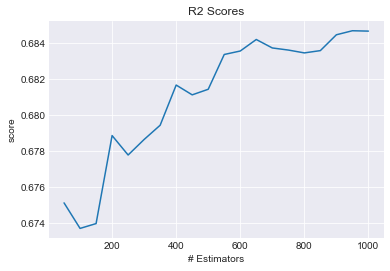

In [96]:
# Boston
print('Setup Model and Run Training Pipeline on Boston Data\n')
model_boston, X_test_boston, y_test_boston = model_training_pipeline(model_rf_boston, df_preprocessed_boston, estimators)

#### 1.2. AdaBoost Regressor

Setup Model and run Training Pipeline on Seattle Data

Separate features (X) and labels (y)...
Split data into training set & test set...
-----------------------------
Model with 50 estimators:
R2 value: 0.356, RMSE: 76.61
-----------------------------
Model with 100 estimators:
R2 value: 0.319, RMSE: 78.81
-----------------------------
Model with 150 estimators:
R2 value: 0.298, RMSE: 79.97
-----------------------------
Model with 200 estimators:
R2 value: 0.291, RMSE: 80.39
-----------------------------
Model with 250 estimators:
R2 value: 0.284, RMSE: 80.80
-----------------------------
Model with 300 estimators:
R2 value: 0.275, RMSE: 81.30
-----------------------------
Model with 350 estimators:
R2 value: 0.274, RMSE: 81.34
-----------------------------
Model with 400 estimators:
R2 value: 0.278, RMSE: 81.13
-----------------------------
Model with 450 estimators:
R2 value: 0.280, RMSE: 81.03
-----------------------------
Model with 500 estimators:
R2 value: 0.280, RMSE: 81.03
---

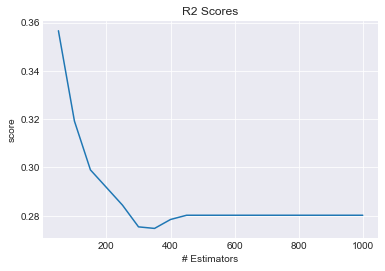

In [97]:
# Seattle
print('Setup Model and run Training Pipeline on Seattle Data\n')
model_seattle, X_test_seattle, y_test_seattle = model_training_pipeline(model_ada_seattle, df_preprocessed_seattle, estimators)

Setup Model and Run Training Pipeline on Boston Data

Separate features (X) and labels (y)...
Split data into training set & test set...
-----------------------------
Model with 50 estimators:
R2 value: 0.523, RMSE: 73.12
-----------------------------
Model with 100 estimators:
R2 value: 0.515, RMSE: 73.72
-----------------------------
Model with 150 estimators:
R2 value: 0.490, RMSE: 75.61
-----------------------------
Model with 200 estimators:
R2 value: 0.471, RMSE: 76.98
-----------------------------
Model with 250 estimators:
R2 value: 0.463, RMSE: 77.55
-----------------------------
Model with 300 estimators:
R2 value: 0.463, RMSE: 77.61
-----------------------------
Model with 350 estimators:
R2 value: 0.463, RMSE: 77.55
-----------------------------
Model with 400 estimators:
R2 value: 0.460, RMSE: 77.79
-----------------------------
Model with 450 estimators:
R2 value: 0.459, RMSE: 77.88
-----------------------------
Model with 500 estimators:
R2 value: 0.457, RMSE: 78.00
----

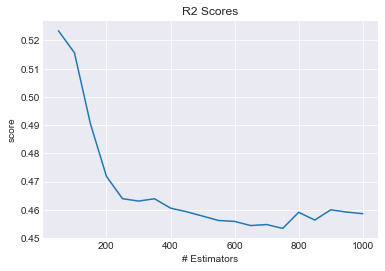

In [98]:
# Boston
print('Setup Model and Run Training Pipeline on Boston Data\n')
model_boston, X_test_boston, y_test_boston = model_training_pipeline(model_ada_boston, df_preprocessed_boston, estimators)

#### 1.3. GradientBoosting Regressor

Setup Model and run Training Pipeline on Seattle Data

Separate features (X) and labels (y)...
Split data into training set & test set...
-----------------------------
Model with 50 estimators:
R2 value: 0.569, RMSE: 62.65
-----------------------------
Model with 100 estimators:
R2 value: 0.586, RMSE: 61.38
-----------------------------
Model with 150 estimators:
R2 value: 0.596, RMSE: 60.65
-----------------------------
Model with 200 estimators:
R2 value: 0.600, RMSE: 60.35
-----------------------------
Model with 250 estimators:
R2 value: 0.602, RMSE: 60.20
-----------------------------
Model with 300 estimators:
R2 value: 0.603, RMSE: 60.11
-----------------------------
Model with 350 estimators:
R2 value: 0.605, RMSE: 60.02
-----------------------------
Model with 400 estimators:
R2 value: 0.606, RMSE: 59.93
-----------------------------
Model with 450 estimators:
R2 value: 0.607, RMSE: 59.86
-----------------------------
Model with 500 estimators:
R2 value: 0.607, RMSE: 59.87
---

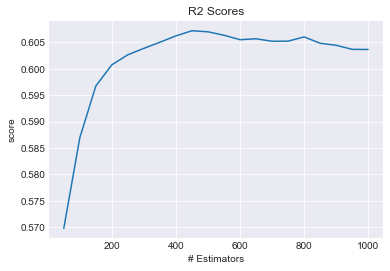

In [99]:
# Seattle
print('Setup Model and run Training Pipeline on Seattle Data\n')
model_seattle, X_test_seattle, y_test_seattle = model_training_pipeline(model_grad_seattle, df_preprocessed_seattle, estimators)

Setup Model and Run Training Pipeline on Boston Data

Separate features (X) and labels (y)...
Split data into training set & test set...
-----------------------------
Model with 50 estimators:
R2 value: 0.702, RMSE: 57.74
-----------------------------
Model with 100 estimators:
R2 value: 0.716, RMSE: 56.35
-----------------------------
Model with 150 estimators:
R2 value: 0.722, RMSE: 55.76
-----------------------------
Model with 200 estimators:
R2 value: 0.726, RMSE: 55.41
-----------------------------
Model with 250 estimators:
R2 value: 0.731, RMSE: 54.85
-----------------------------
Model with 300 estimators:
R2 value: 0.732, RMSE: 54.76
-----------------------------
Model with 350 estimators:
R2 value: 0.736, RMSE: 54.42
-----------------------------
Model with 400 estimators:
R2 value: 0.737, RMSE: 54.23
-----------------------------
Model with 450 estimators:
R2 value: 0.740, RMSE: 54.00
-----------------------------
Model with 500 estimators:
R2 value: 0.738, RMSE: 54.13
----

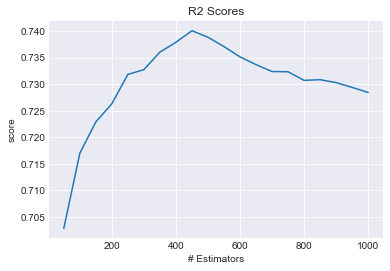

In [100]:
# Boston
print('Setup Model and Run Training Pipeline on Boston Data\n')
model_boston, X_test_boston, y_test_boston = model_training_pipeline(model_grad_boston, df_preprocessed_boston, estimators)

#### Model Selection
The GradientBoosting Regressor has the highest R2 score, R2=0.61 in case of Seattle and R2=0.74 in case of Boston, and thus achieves the best price predictions. Best reults are achieved when choosing 450 estimators.

In [101]:
# Choosing best performing model (GradientBoosting Regressor) and train it again with 450 estimators
model_grad_seattle = GradientBoostingRegressor(random_state=42, n_estimators=450)
model_grad_boston = GradientBoostingRegressor(random_state=42, n_estimators=450)

# Training (Seattle)
y = df_preprocessed_seattle['price']
X = df_preprocessed_seattle.copy(deep=True)
X.drop(columns=['price'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_grad_seattle.fit(X_train, y_train)
y_pred = model_grad_seattle.predict(X_test)
r2_seattle = r2_score(y_test, y_pred)

# Training (Boston)
y = df_preprocessed_boston['price']
X = df_preprocessed_boston.copy(deep=True)
X.drop(columns=['price'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_grad_boston.fit(X_train, y_train)
y_pred = model_grad_boston.predict(X_test)
r2_boston = r2_score(y_test, y_pred)

# Print R2 Scores again (Validation)
print('R2 Score on Seattle\'s Data: ' + str(r2_seattle)[:5])
print('R2 Score on Boston\'s Data: ' + str(r2_boston)[:5])

R2 Score on Seattle's Data: 0.607
R2 Score on Boston's Data: 0.740


### 4. Permutation Importance of Features

In [102]:
print('Permutation Importance of Features (Seattle):')
perm_seattle = PermutationImportance(model_grad_seattle, random_state=42).fit(X_test_seattle, y_test_seattle)
eli5.show_weights(perm_seattle, top=X_test_seattle.shape[1], feature_names = X_test_seattle.columns.tolist())

Permutation Importance of Features (Seattle):


Weight,Feature
0.2051 ± 0.0512,bedrooms
0.0876 ± 0.0199,cleaning_fee
0.0445 ± 0.0149,bathrooms
0.0393 ± 0.0512,accommodates
0.0344 ± 0.0068,room_type_Entire home/apt
0.0158 ± 0.0083,extra_people
0.0114 ± 0.0067,neighbourhood_group_cleansed_Downtown
0.0092 ± 0.0106,beds
0.0083 ± 0.0046,availability_365
0.0076 ± 0.0070,neighbourhood_group_cleansed_Capitol Hill


In [103]:
print('Permutation Importance of Features (Boston):')
perm_boston = PermutationImportance(model_grad_boston, random_state=42).fit(X_test_boston, y_test_boston)
eli5.show_weights(perm_boston, top=X_test_boston.shape[1], feature_names = X_test_boston.columns.tolist())

Permutation Importance of Features (Boston):


Weight,Feature
0.3214 ± 0.0563,bedrooms
0.1076 ± 0.0193,room_type_Entire home/apt
0.0539 ± 0.0387,bathrooms
0.0522 ± 0.0256,cleaning_fee
0.0297 ± 0.0120,reviews_per_month
0.0259 ± 0.0171,neighbourhood_cleansed_Beacon Hill
0.0200 ± 0.0073,availability_30
0.0156 ± 0.0062,guests_included
0.0132 ± 0.0095,accommodates
0.0112 ± 0.0103,availability_365


## Conclusion

##### 1. What is the market situation like in both cities? Are there differences?

The number of ratings and thus the number of bookings increases rapidly over time in Seattle and Boston. The market growth increases exponentially in both cities, whereby the groth curve is steeper for Seattle. The number of bookings reaches its minimum in the winter months and its maximum in the summer months.

The average Airbnb accomodation price is by far higher in Boston (174\$) than in Seattle (128\$). The standard deviation is by far higher in Boston (std=148) than in Seattle (std=90). So the market in Boston is more differentiated. Most accomodations are offered at a round price such as 100$ as the peaks in the distributions show.

A noticeable effect is that the prices rise the closer the accommodation is to the city centre. When comparing the average price range of the neigbourhoods in both cities, the higher price differentiation of Boston's market becomes clear, again. Even though the average Airbnb accomodation prices are by far higher in Boston, there are neighbourhoods with significantly lower average prices than in Seattle.

##### 2. Which are the most expensive neighbourhoods? And in which neighbourhoods most accomodations are offered? 

A noticeable effect is that the prices rise the closer the accommodation is to the city centre. This becomes especially apparent in the case of Boston. When comparing the average price range of the neigbourhoods in both cities, the higher price differentiation of Boston's market becomes clear again. Even though the average Airbnb accomodation prices are by far higher in Boston, there are neighbourhoods with significantly lower average prices than in Seattle.

In Seattle most listings are located in the central neighbourhoods (Queen Anne, Downtown, Capitol Hill, Cascade, Ballard and Central Area) and in West Seattle. These accomodations are offered within the average price range 120\$ - 157\$ (other neighbourhoods not taken into account). Higher prices are only taken in Magnolia, which is a peninsula in the northwest of Seattle, next to Discovery Park. In Boston the distribution of listings is not that centralized. There are many accomodations offered in less centrally located neighbourhoods such as Dorchester and Jamaica Plain. The highest prices are taken in centrally located neighbourhoods such as Waterfront, Bay Village, Black Bay and Downtown.

##### 3. What are the main price drivers for Airbnb listings in these two cities?
In both cities the main price driver for an Airbnb accomodation is the number of bedrooms. Room type (entire appartment/house), cleaning fee and number of bathrooms are listed under the main price drivers in both cities, as well. Additionally, the number of acomodates belongs to the main price drivers in case of Seattle and the number of reviews in case of Boston.
Furthermore, in both cases a neighbourhood is listed under the top price drivers, Beacon Hill in Boston and Downtown in Seattle.